In [35]:
import numpy as np
import fnmatch
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import keras
from keras import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, LeakyReLU
import keras.backend as kb
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import scikeras
from scikeras.wrappers import KerasClassifier, KerasRegressor
from joblib import Parallel, delayed
import joblib

In [36]:
#For when working on Google Colab, mount the drive
#from google.colab import drive
#drive.mount('/content/drive')

In [37]:
#For when working on Google Colab, change to the appropriate directory
#os.chdir('drive/MyDrive/292B Final/')

#In all cases, get the current directory for file saving/loading
dir = os.getcwd()

In [38]:
#Function - get image data from folder and assign to variables
def getData(vers):

    #Folder of dataset
    direc=dir + '/Distance/Inputs/ImgProcessed/'+ vers + '/'

    #Initialize storage variables
    #Number of images in dataset
    n=len(fnmatch.filter(os.listdir(direc), '*.jpg'))

    #Processed image size
    pix=np.array(Image.open(direc+os.listdir(direc)[0])).shape[0]

    #Full set of images
    imgall=np.zeros([n,pix,pix])

    #Actual distances
    y=np.zeros([n,1])

    #Image name
    imgname = np.full([n, 1], "", dtype=object)
    
    #Iterate over files in the directory
    for i, file in enumerate(sorted(os.listdir(direc))):

        #Get full file path                     
        filename = os.path.join(direc, file)
        #Double check to ensure it is a valid file
        if os.path.isfile(filename):

            #Store image data as array                 
            imgall[i,:,:]=np.array(Image.open(filename))

            #Store the distance values
            y[i]=float(file.rsplit('_', 1)[0].replace('Conv_',''))

            #Store the image name
            imgname[i]=file

    #Convert to float32 and rescale/normalize the pixel values to be 0-1
    imgall=imgall.astype('float32')/255
    imgall=imgall.reshape(-1,pix,pix,1)
    
    return imgall,y,imgname,pix

In [39]:
#Get the default processed imageset used for model training
imgall,y,imgname,pix = getData('V1')

#Normalize the distances
ymed=np.median(y)
y=y/ymed

#Split the images, encodings, and file labels into training and test datasets
#imgtrain, imgtest, ytrain, ytest, imgnametrain, imgnametest = train_test_split(imgall, y, imgname, test_size=0.2, stratify=y)

#Load the utilized data split from file, if necessary
imgtrain, imgtest, ytrain, ytest, imgnametrain, imgnametest = joblib.load(dir + '/Distance/Inputs/train_test_distance.pkl')

In [18]:
#Function to build ML model
def build_clf(fnum1, fnum2, fnum3, fnum4, do):
    #Build the model
    mod = Sequential()

    #Convolution and pooling 1
    mod.add(Conv2D(fnum1, kernel_size=(3, 3),activation=tf.keras.layers.LeakyReLU(alpha=0.1),input_shape=(pix,pix,1),padding='same'))
    mod.add(MaxPooling2D((2, 2),padding='same'))
    mod.add(Dropout(do))

    #Convolution and pooling 2
    mod.add(Conv2D(fnum2, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.1),padding='same'))
    mod.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
    mod.add(Dropout(do))

    #Convolution and pooling 3
    mod.add(Conv2D(fnum3, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.1),padding='same'))                 
    mod.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
    mod.add(Dropout(do))

    #Fully connected
    mod.add(Flatten())
    mod.add(Dense(fnum4, activation=tf.keras.layers.LeakyReLU(alpha=0.1)))
    mod.add(Dropout(do))
    mod.add(Dense(1, activation='linear'))

    #Compile the model
    mod.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam())
    return mod

In [ ]:
#DON'T RUN THIS CELL UNLESS WANTING TO RE-OPTIMIZE (takes long time + GPU)
#Hyperparameter optimization:
#Make wrapper for Keras model in order to do scikit hyperparameter search
clf = KerasRegressor(model=build_clf, fnum1=16, fnum2=16, fnum3=16, fnum4=16, do=0)

#Set test values for model hyperparameters
params={'batch_size':[12, 25, 50],
        'epochs':[12],
        'fnum1':[16,32,64,128],
        'fnum2':[16,32,64,128],
        'fnum3':[16,32,64,128],
        'fnum4':[16,32,64,128],
        'do':[0,.1,.25],
        }

#Perform Randomized CV search:
#Run model with various assortments of hyperparameters and measure performance
rs = RandomizedSearchCV(estimator=clf, param_distributions = params, scoring='neg_mean_absolute_error', n_iter = 100, cv=5, verbose=3, return_train_score=True)
rs_result = rs.fit(imgtrain, ytrain)

In [ ]:
#Get output from RandomizedCV search

#Save the results table
#df = pd.DataFrame(rs_result.cv_results_)
#df.to_csv('./Distance/SearchCV/RandomizedSearchCV_ResultsDistance.csv')

#Save the best parameters and estimator as a pickle files
#best_params = rs_result.best_params_
#best_model = rs_result.best_estimator_
#joblib.dump(best_params, 'best_parameters_distance.pkl')
#joblib.dump(best_model, 'best_estimator_distance.pkl')

#If re-loading later from external file:
best_params = joblib.load(dir + '/Distance/SearchCV/best_parameters_distance.pkl')
modelfinal = joblib.load(dir + '/Distance/SearchCV/best_estimator_distance.pkl')

In [8]:
#Refit again after CV search on whole training set (optional, but allows for training on whole training set)
#Set optimized best parameters
fnum1 = best_params['fnum1']
fnum2 = best_params['fnum2']
fnum3 = best_params['fnum3']
fnum4 = best_params['fnum4']
do = best_params['do']
batch = best_params['batch_size']

#Set up early stopping if performance improvement tapers 
es = keras.callbacks.EarlyStopping(
    monitor='loss',
    mode='min',
    patience = 10,
    restore_best_weights = True,
    verbose=1)

#Build model with best parameters found in randomized search
batch_size = batch
epochs = 100
modelfinal=build_clf(fnum1=fnum1,fnum2=fnum2,fnum3=fnum3,fnum4=fnum4,do=do)

#Train model
trainfinal = modelfinal.fit(imgtrain,ytrain, batch_size=batch_size, epochs=epochs,callbacks=[es], verbose=1)

#Save the model for future use
joblib.dump(trainfinal, dir + '/Distance/ModelFit/trainfinal_distance.pkl')
joblib.dump(modelfinal, dir + '/Distance/ModelFit/modelfinal_distance.pkl')

#Output some performance metrics
loss_hist = trainfinal.history['loss']
best_epoch = np.argmin(trainfinal.history['loss']) + 1
print('Best epoch = ', best_epoch)
print('Smallest loss =', np.min(loss_hist))

Epoch 1/100
9/9 [==============================] - 4s 72ms/step - loss: 0.8885
Epoch 2/100
9/9 [==============================] - 0s 54ms/step - loss: 0.5077
Epoch 3/100
9/9 [==============================] - 0s 54ms/step - loss: 0.3511
Epoch 4/100
9/9 [==============================] - 0s 54ms/step - loss: 0.2290
Epoch 5/100
9/9 [==============================] - 0s 54ms/step - loss: 0.1890
Epoch 6/100
9/9 [==============================] - 0s 54ms/step - loss: 0.1705
Epoch 7/100
9/9 [==============================] - 0s 54ms/step - loss: 0.1631
Epoch 8/100
9/9 [==============================] - 0s 54ms/step - loss: 0.1398
Epoch 9/100
9/9 [==============================] - 0s 55ms/step - loss: 0.1473
Epoch 10/100
9/9 [==============================] - 0s 55ms/step - loss: 0.1095
Epoch 11/100
9/9 [==============================] - 0s 55ms/step - loss: 0.0870
Epoch 12/100
9/9 [==============================] - 1s 57ms/step - loss: 0.0668
Epoch 13/100
9/9 [==============================]

INFO:tensorflow:Assets written to: C:\Users\jadoyle\AppData\Local\Temp\tmp7znass11\assets


INFO:tensorflow:Assets written to: C:\Users\jadoyle\AppData\Local\Temp\tmp7znass11\assets


INFO:tensorflow:Assets written to: C:\Users\jadoyle\AppData\Local\Temp\tmpdf90_e_c\assets


INFO:tensorflow:Assets written to: C:\Users\jadoyle\AppData\Local\Temp\tmpdf90_e_c\assets


Best epoch =  38
Smallest loss = 0.024584854021668434


In [ ]:
#Or load previously trained model
trainfinal = joblib.load(dir + '/Distance/ModelFit/trainfinal_distance.pkl')
modelfinal = joblib.load(dir + '/Distance/ModelFit/modelfinal_distance.pkl')

#Output some performance metrics
loss_hist = trainfinal.history['loss']
best_epoch = np.argmin(trainfinal.history['loss']) + 1
print('Best epoch = ', best_epoch)
print('Smallest loss =', np.min(loss_hist))

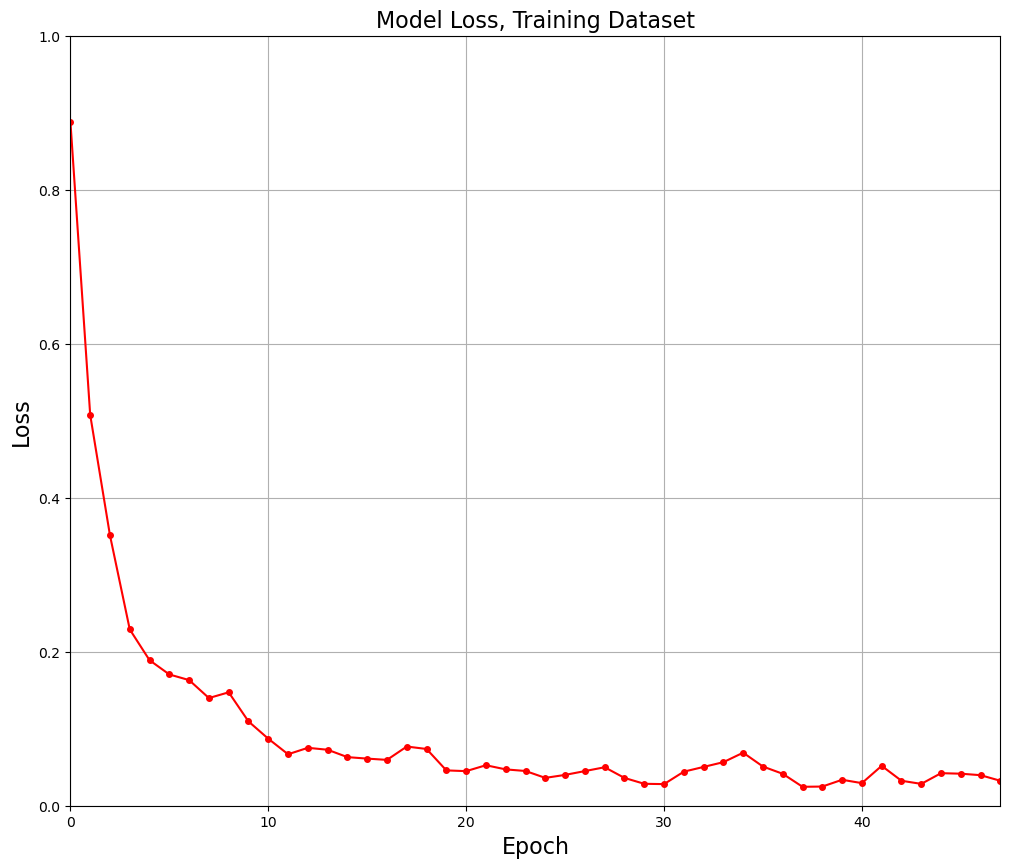

In [19]:
#Model training history
#Plot loss
plt.figure(figsize=(12,10))
plt.plot(range(len(loss_hist)), loss_hist, 'r', linewidth=1.5, marker ='.', markersize=8, label='Training Data')
plt.title('Model Loss, Training Dataset', fontsize=16)
plt.xlim(0,len(loss_hist)-1)
plt.ylim(0,np.ceil(np.max(loss_hist)/.5)*.5)
plt.xlabel('Epoch',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.grid()

In [20]:
#Function to use model for predicition, calculate error
def modelPred(imgdata, y, ymed, dataset):
    #Predict the outcomes for the training and test data using the trained model
    y_pred=modelfinal.predict(imgdata)
    
    #Output loss values
    print('{} MAE (Normalized):'.format(dataset), np.mean(np.abs(y_pred-y)))
    print('{} MAE (Denormalized):'.format(dataset), ymed*np.mean(np.abs(y_pred-y)))
    
    return y_pred

In [26]:
#Function to plot performance (prediction) results
def plotResults(y, y_pred, ymed, dataset):
    plt.figure(figsize=(10,8))
    plt.plot([0,60],[0,60], linestyle='dashed', color='red', label='Perfect Correspondence')
    plt.scatter(y*ymed,y_pred*ymed)
    plt.xlim(0,55)
    plt.ylim(0,np.ceil(np.max(ytrain_pred*ymed)/10.0)*10)
    plt.xlabel('Measured Distance (inches)', fontsize=16);
    plt.ylabel('Predicted Distance (inches)', fontsize=16);
    plt.title('Measured vs. Predicted Distance, {} Dataset'.format(dataset), fontsize=16);
    plt.legend(loc ="lower right", fontsize=14)
    plt.savefig(dir + '/Distance/Plots/{}_pred_ranked_Distance.png'.format(dataset))
    plt.grid()

In [22]:
#Function to calculate %error between actual and predicted values, then rank from worst to best
def rankedPreds(ypred, ydata, imgname, dataset):
    
    err=np.zeros([ypred.shape[0],1])
    for i in range(ypred.shape[0]):
        err[i] = 100*np.abs(ydata[i]-ypred[i])/ydata[i]

    y_compare=np.hstack([ypred,ydata, err, imgname])
    df = pd.DataFrame(y_compare, columns = ['Prediction','Actual','Percent Error','Image Number'])
    df = df.sort_values(by=['Percent Error'], ascending=False)
    
    df.to_csv(dir + '/Distance/RankedPreds/{}_pred_ranked_Distance.csv'.format(dataset))
    
    return df

4/4 [==============================] - 0s 124ms/step
Training MAE (Normalized): 0.01794985203515915
Training MAE (Denormalized): 0.4936209309668766
1/1 [==============================] - 0s 16ms/step
Test MAE (Normalized): 0.07077144334211895
Test MAE (Denormalized): 1.946214691908271


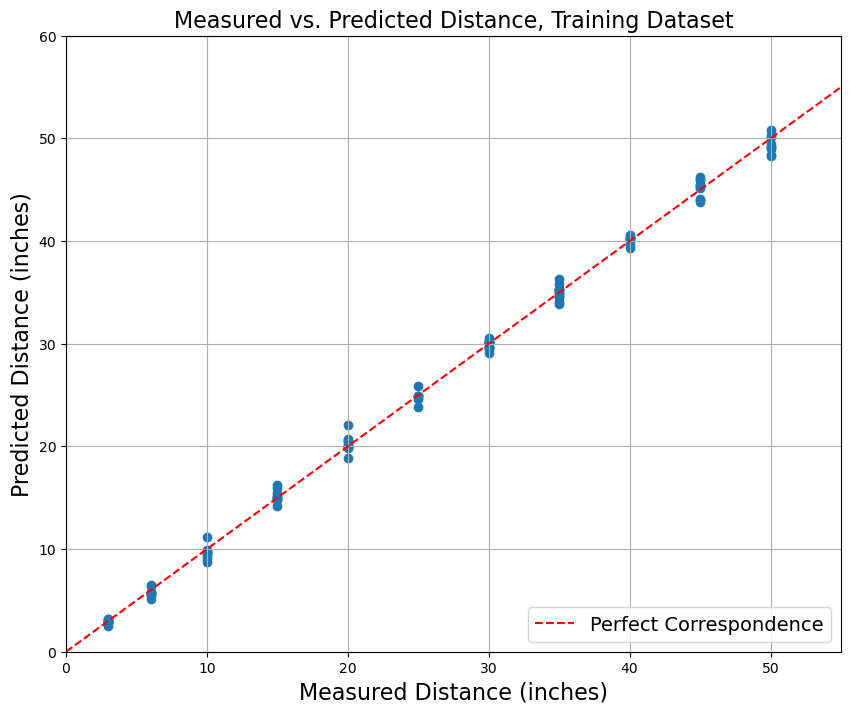

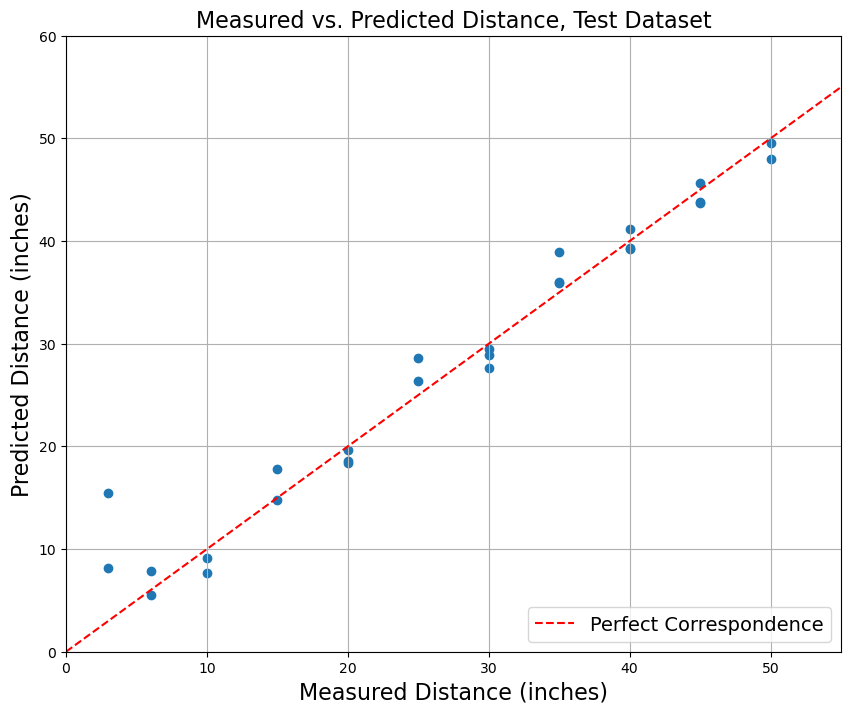

In [27]:
#Model performance
ytrain_pred = modelPred(imgtrain, ytrain, ymed, 'Training')
ytest_pred = modelPred(imgtest, ytest, ymed, 'Test')

#Plot results
plotResults(ytrain, ytrain_pred, ymed, 'Training')
plotResults(ytest, ytest_pred, ymed, 'Test')

In [28]:
#Model performance
#Calculate and show ranked error
train_ranked = rankedPreds(ytrain_pred*ymed, ytrain*ymed, imgnametrain, 'train')
test_ranked = rankedPreds(ytest_pred*ymed, ytest*ymed, imgnametest, 'test')

#Display results in browser
display(train_ranked)
display(test_ranked)

,Prediction,Actual,Percent Error,Image Number
65,2.504349,3.0,16.521708,Conv_3_4.jpg
48,5.183794,6.0,13.603425,Conv_6_2.jpg
35,8.69458,10.0,13.054199,Conv_10_6.jpg
42,11.1694,10.0,11.694002,Conv_10_3.jpg
63,22.117069,20.0,10.585346,Conv_20_10.jpg
...,...,...,...,...
36,40.083309,40.0,0.208273,Conv_40_2.jpg
60,34.929413,35.0,0.201678,Conv_35_6.jpg
98,39.921837,40.0,0.195408,Conv_40_3.jpg
100,30.057276,30.0,0.190919,Conv_30_8.jpg


,Prediction,Actual,Percent Error,Image Number
12,15.474912,3.0,415.83039,Conv_3_7.jpg
24,8.15998,3.0,171.999327,Conv_3_10.jpg
11,7.85275,6.0,30.879172,Conv_6_9.jpg
13,7.694668,10.0,23.053322,Conv_10_4.jpg
18,17.831638,15.0,18.877589,Conv_15_11.jpg
2,28.657408,25.0,14.629631,Conv_25_2.jpg
17,38.951889,35.0,11.291112,Conv_35_10.jpg
21,9.142219,10.0,8.577814,Conv_10_10.jpg
0,18.391806,20.0,8.040972,Conv_20_1.jpg
4,27.671436,30.0,7.761879,Conv_30_1.jpg


5/5 [==============================] - 0s 91ms/step
DistortedV7 MAE (Normalized): 0.4396071430244393
DistortedV7 MAE (Denormalized): 12.08919643317208


,Prediction,Actual,Percent Error,Image Number
78,44.914574,3.0,1397.152456,Conv_3_3.jpg
74,40.63253,3.0,1254.417674,Conv_3_1.jpg
80,31.498323,3.0,949.944115,Conv_3_5.jpg
121,50.837811,6.0,747.296842,Conv_6_1.jpg
82,22.570459,3.0,652.348646,Conv_3_7.jpg
...,...,...,...,...
95,40.273472,40.0,0.68368,Conv_40_8.jpg
114,50.323551,50.0,0.647102,Conv_50_3.jpg
7,9.942721,10.0,0.572786,Conv_10_7.jpg
49,29.927017,30.0,0.243276,Conv_30_14.jpg


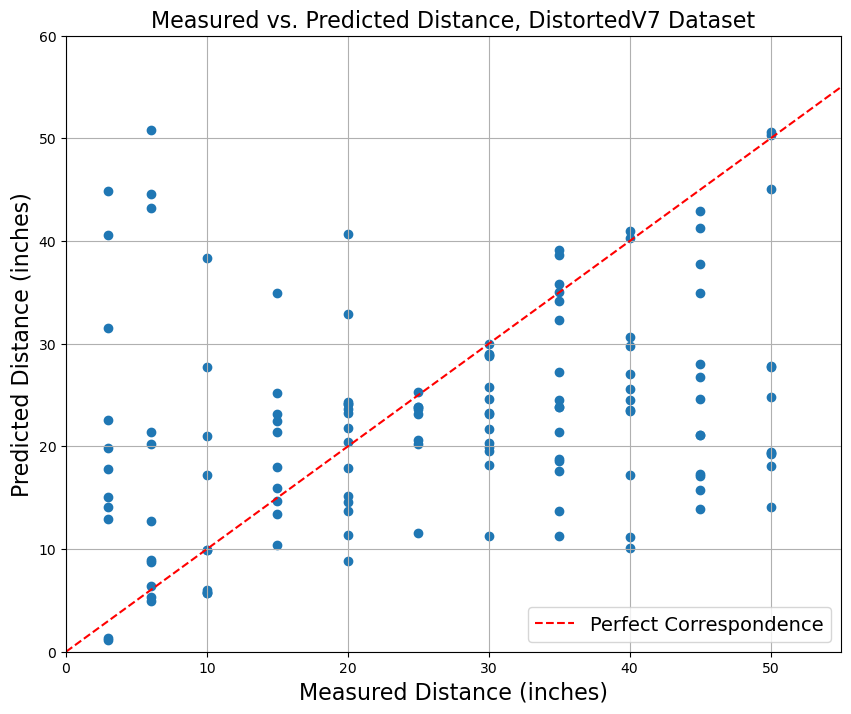

In [34]:
#Test other distorted image datasets on model to see how they perform

#Folder location within ./Images/
folder='V7'
dis_name = 'DistortedV7'

#Get the desired imageset
imgall_dis,y_dis,imgname_dis,pix_dis = getData(folder)

#Normalize the distances
#Use training ymed - don't calculate new value
y_dis=y_dis/ymed

#Model performance
y_dis_pred = modelPred(imgall_dis, y_dis, ymed, dis_name)

#Plot results
plotResults(y_dis, y_dis_pred, ymed, dis_name)

#Calculate and show ranked error
train_ranked = rankedPreds(y_dis_pred*ymed, y_dis*ymed, imgname_dis, dis_name)
display(train_ranked)